# A PyTorch Audio coding example

In [1]:
import torch
import torch.nn
import torchaudio
import torchaudio.functional as taf
print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.5.0
2.5.0


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
SPEECH_file = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

### Create a Wav2Vec2 model that does the feature extraction.

This is trained in a self supervized manner with audio only for representation learning then fine tuned with labels for specific tasks. There is also the ´Hubert model` that is trained in the same way. There are plenty of pretrained models in [torchaudio.pipelines](https://pytorch.org/audio/stable/pipelines.html#module-torchaudio.pipelines) to choose from.

We will use [torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H](https://pytorch.org/audio/stable/pipelines.html#module-torchaudio.pipelines) here.

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample Rate: {bundle.sample_rate}")
print(f"Labels: {bundle.get_labels()}")

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
model = bundle.get_model().to(device)

### Loading Data 


In [5]:
IPython.display.Audio(SPEECH_file)

In [6]:
#list(model.parameters())
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [7]:
waveform, sample_rate = torchaudio.load(SPEECH_file)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = taf.resample(waveform, 
                            sample_rate,
                           bundle.sample_rate)

### Extracting acoustic features

Although Wav2Vec2 models fine-tuned for ASR tasks can perform feature extraction AND classification in just a single step.  For sake of argument, we will only do feature extraction

In [8]:
model.eval()  # why does ssome tutoriald leave this out?
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

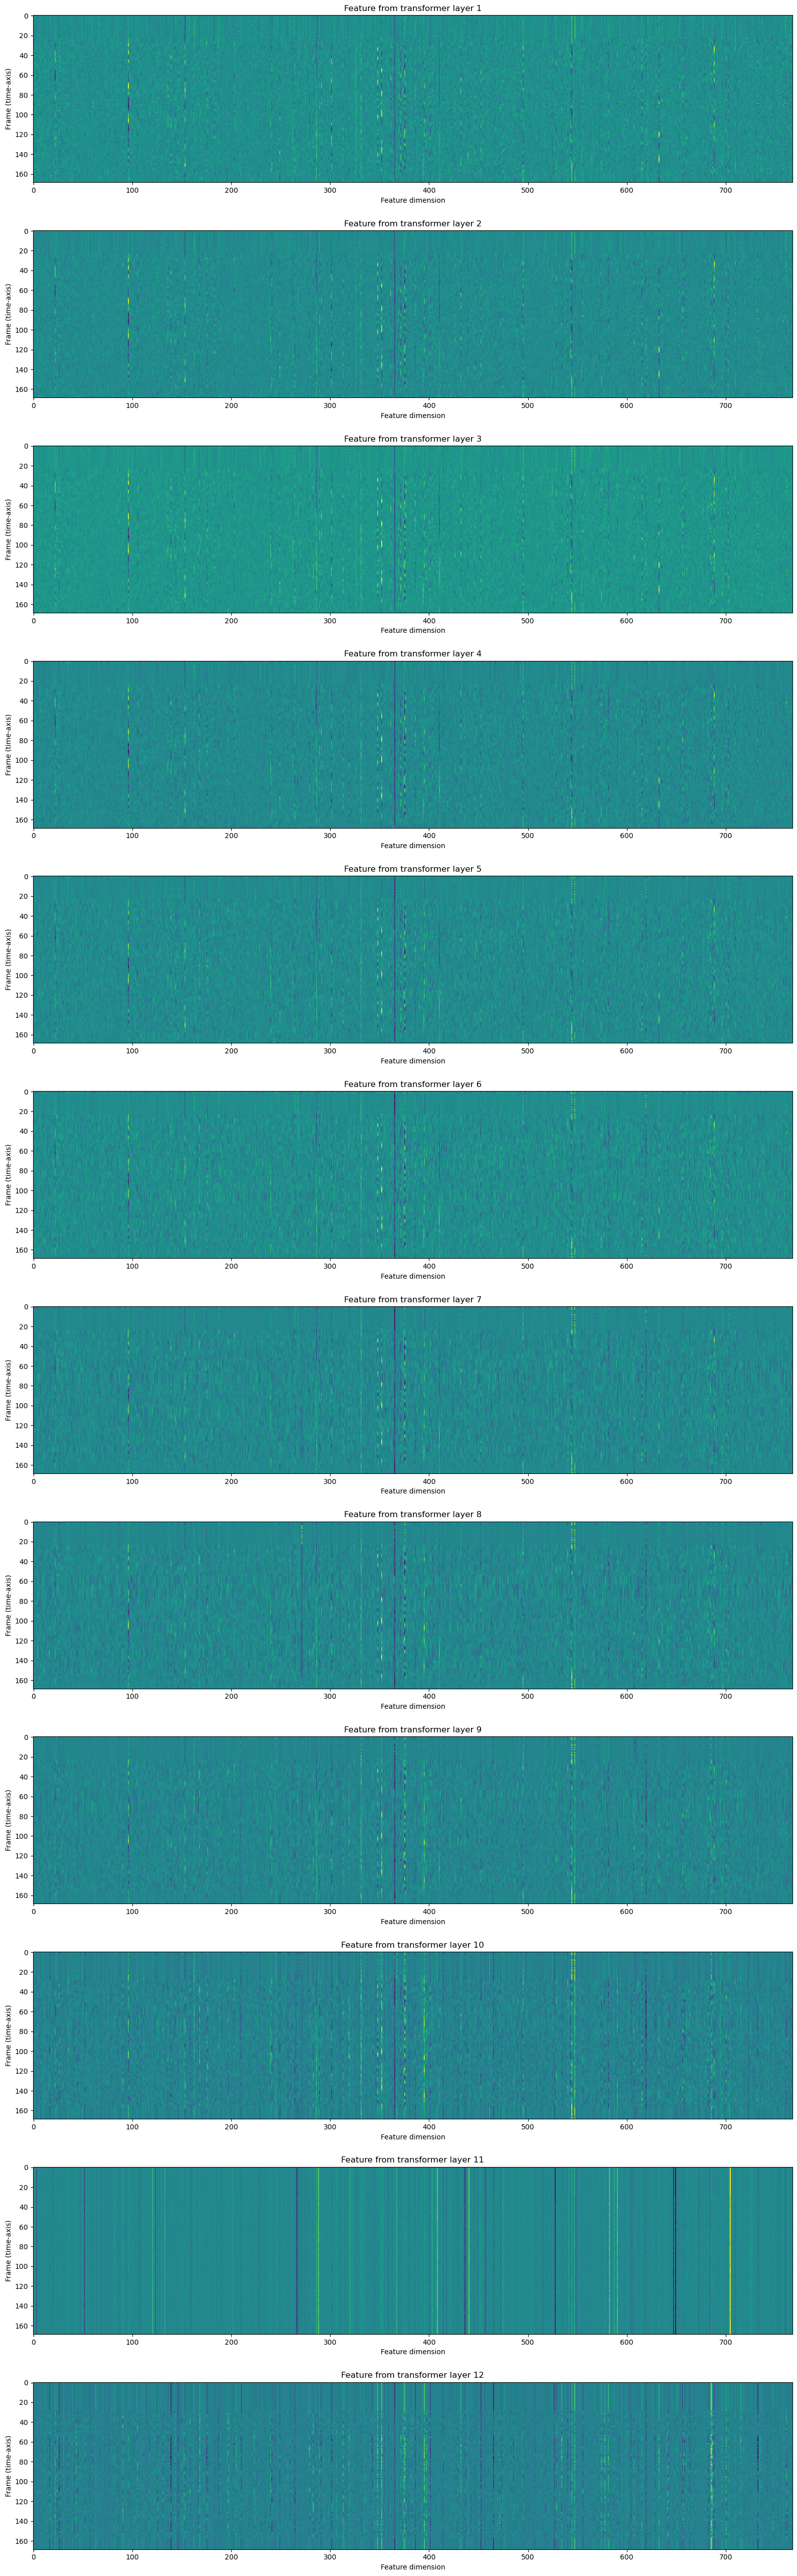

In [9]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

### Feature classification
Once the features are extracted, the next step is ot classify them into categories-
Wav2Vec2 model provides method to perform the feature extraction and classification in one step.

In [10]:
with torch.inference_mode():
    emission, _ = model(waveform)
#output is logits

In [11]:
# Let'S visualize this:


Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


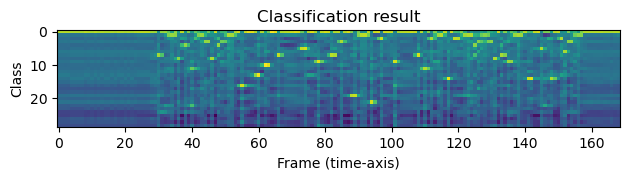

In [12]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

### Generating transcripts
From the sequence of label probabilities, now we want to generate transcripts. The process to generate hypotheses is often called “decoding”.

Decoding is more elaborate than simple classification because decoding at certain time step can be affected by surrounding observation

For example, take a word like night and knight. Even if their prior probability distribution are differnt (in typical conversations, night would occur way more often than knight), to accurately generate transcripts with knight, such as a knight with a sword, the decoding process has to postpone the final decision until it sees enough context.

There are many decoding techniques proposed, and they require external resources, such as word dictionary and language models.

In this tutorial, for the sake of simplicity, we will perform greedy decoding which does not depend on such external components, and simply pick up the best hypothesis at each time step. Therefore, the context information are not used, and only one transcript can be generated.

We start by defining greedy decoding algorn.Modules.

In [13]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emmission: torch.Tensor) -> str:
        """Given the sequence emission over labels, get the best path string
        Args:
            emission (Tensor): Logit tensors. Shape `[num_seq, num_labels]`.
            
        Returns:
            str: THe resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices[0] if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [14]:
# Now create the decoder object and decode the transcript
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])   #.squeeze())

In [15]:
print(transcript)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
